<a href="https://colab.research.google.com/github/xxl5455/DS340/blob/main/DS340W.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install haversine

In [4]:
pip install xgboost

In [5]:
# Data processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from haversine import haversine, Unit

# Load the Citi-bike datasets

In [6]:
# loading the csv data to a Pandas DataFrame
data1904 = pd.read_csv('/content/drive/My Drive/DS340w/JC-201904-citibike-tripdata.csv')
data1905 = pd.read_csv('/content/drive/My Drive/DS340w/JC-201905-citibike-tripdata.csv')
data1906 = pd.read_csv('/content/drive/My Drive/DS340w/JC-201906-citibike-tripdata.csv')
data2004 = pd.read_csv('/content/drive/My Drive/DS340w/JC-202004-citibike-tripdata.csv')
data2005 = pd.read_csv('/content/drive/My Drive/DS340w/JC-202005-citibike-tripdata.csv')
data2006 = pd.read_csv('/content/drive/My Drive/DS340w/JC-202006-citibike-tripdata.csv')
data2104 = pd.read_csv('/content/drive/My Drive/DS340w/JC-202104-citibike-tripdata.csv')
data2105 = pd.read_csv('/content/drive/My Drive/DS340w/JC-202105-citibike-tripdata.csv')
data2106 = pd.read_csv('/content/drive/My Drive/DS340w/JC-202106-citibike-tripdata.csv')
data2204 = pd.read_csv('/content/drive/My Drive/DS340w/JC-202204-citibike-tripdata.csv')
data2205 = pd.read_csv('/content/drive/My Drive/DS340w/JC-202205-citibike-tripdata.csv')
data2206 = pd.read_csv('/content/drive/My Drive/DS340w/JC-202206-citibike-tripdata.csv')
data2304 = pd.read_csv('/content/drive/My Drive/DS340w/JC-202304-citibike-tripdata.csv')
data2305 = pd.read_csv('/content/drive/My Drive/DS340w/JC-202305-citibike-tripdata.csv')
data2306 = pd.read_csv('/content/drive/My Drive/DS340w/JC-202306-citibike-tripdata.csv')

In [7]:
select_columns = ['starttime', 'stoptime', 'start station id', 'start station name', 'start station latitude', 'start station longitude', 'end station id', 'end station name', 'end station latitude', 'end station longitude', 'usertype', 'tripduration' ]
data1904 = data1904[select_columns]
data1905 = data1905[select_columns]
data1906 = data1906[select_columns]
data2004 = data2004[select_columns]
data2005 = data2005[select_columns]
data2006 = data2006[select_columns]

# Concatenate the selected data from all DataFrames into one
combined_df = pd.concat([data1904, data1905, data1906, data2004, data2005, data2006], ignore_index=True)

dataframes = [data2104, data2105, data2106, data2204, data2205, data2206, data2304, data2305, data2306]
columns_to_delete = ['ride_id', 'rideable_type']

# Iterate over the list of DataFrames and delete the column
for df in dataframes:
    df.drop(columns=columns_to_delete, inplace=True)

combined_df2 = pd.concat([data2104, data2105, data2106, data2204, data2205, data2206, data2304, data2305, data2306], ignore_index=True)
# Convert the start_time and end_time columns to datetime
combined_df2['started_at'] = pd.to_datetime(combined_df2['started_at'])
combined_df2['ended_at'] = pd.to_datetime(combined_df2['ended_at'])
combined_df2['duration in day'] = (combined_df2['ended_at'] - combined_df2['started_at'])

# Convert the duration to seconds
combined_df2['duration'] = combined_df2['duration in day'].dt.total_seconds()
del combined_df2['duration in day']

In [8]:
# Unify the column names of datasets
combined_df = combined_df.rename(columns={'starttime': 'started_at', 'stoptime': 'ended_at',
                                          'start station id':'start_station_id', 'start station name':'start_station_name',
                                          'start station latitude': 'start_lat', 'start station longitude': 'start_lng',
                                          'end station id':'end_station_id', 'end station name':'end_station_name',
                                          'end station latitude': 'end_lat', 'end station longitude': 'end_lng',
                                          'usertype': 'member_casual', 'tripduration': 'duration'})

# Unify the column types of datasets
# Convert datetime columns in combined_df to datetime
combined_df['started_at'] = pd.to_datetime(combined_df['started_at'])
combined_df['ended_at'] = pd.to_datetime(combined_df['ended_at'])

# Convert station ID columns in both DataFrames to object(string)
combined_df['start_station_id'] = combined_df['start_station_id'].astype(str)
combined_df['end_station_id'] = combined_df['end_station_id'].astype(str)
combined_df2['start_station_id'] = combined_df2['start_station_id'].astype(str)
combined_df2['end_station_id'] = combined_df2['end_station_id'].astype(str)


# Convert duration columns in combined_df2 to int
combined_df2['duration'] = combined_df2['duration'].astype(int)

In [9]:
# After aligning data types, you can perform the join
bike = pd.merge(combined_df, combined_df2, on=['started_at', 'ended_at', 'start_station_name', 'start_station_id',
                                               'end_station_name', 'end_station_id', 'start_lat', 'start_lng',
                                               'end_lat', 'end_lng', 'member_casual', 'duration'], how='outer')

In [10]:
bike.isnull().sum()

started_at               0
ended_at                 0
start_station_id         0
start_station_name      58
start_lat                0
start_lng                0
end_station_id           0
end_station_name      1885
end_lat               1262
end_lng               1262
member_casual            0
duration                 0
dtype: int64

In [11]:
bike = bike.dropna()
#checking nul values in each columns
bike.isnull().sum()
#Count unique values each columns
bike.nunique()

started_at            820167
ended_at              820830
start_station_id         282
start_station_name       228
start_lat              48982
start_lng              49829
end_station_id           507
end_station_name         430
end_lat                  516
end_lng                  516
member_casual              4
duration               12972
dtype: int64

In [12]:
# Remove extreme outliers, trip duration less than 1 minutes and more than 12 hours
bike = bike[(bike['duration'] <= 3600*12) & (bike['duration'] > 60)]

count    823922.000000
mean        884.795851
std        1565.513640
min          61.000000
25%         285.000000
50%         468.000000
75%         879.000000
max       43186.000000
Name: duration, dtype: float64


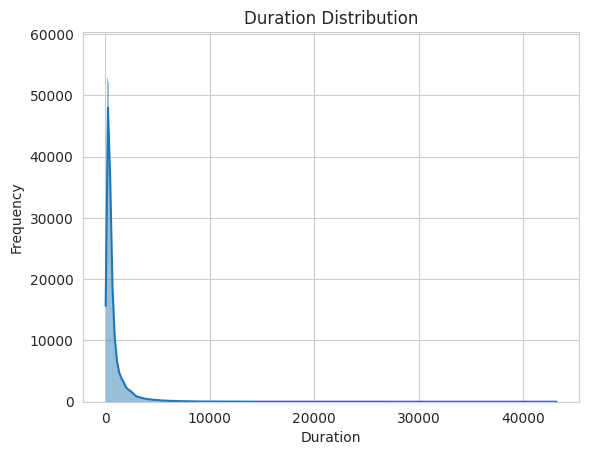

In [13]:
print(bike['duration'].describe())
# Set the aesthetic style of the plots
sns.set_style('whitegrid')

# Create the histogram
sns.histplot(bike['duration'], bins=1000, kde=True)  # 'kde' adds a Kernel Density Estimate line
plt.title('Duration Distribution')
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.show()


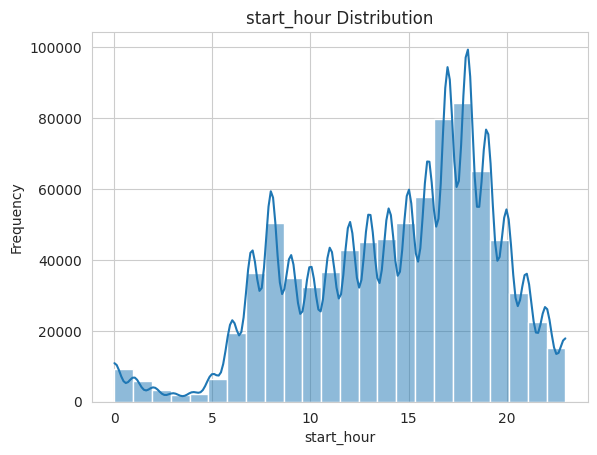

In [14]:
bike.loc[:, 'start_hour'] = bike['started_at'].dt.hour

# Create the histogram
sns.histplot(bike['start_hour'], bins=24, kde=True)  # 'kde' adds a Kernel Density Estimate line
plt.title('start_hour Distribution')
plt.xlabel('start_hour')
plt.ylabel('Frequency')
plt.show()

# Load the weather datasets

In [15]:
nycWeather = pd.read_csv('/content/drive/My Drive/DS340w/NYC_Central_Park_weather_1869-2022.csv')
nycWeather['DATE'] = pd.to_datetime(nycWeather['DATE'])

In [16]:
nycWeather['DATE'] = pd.to_datetime(nycWeather['DATE'])
weather = nycWeather[(nycWeather['DATE'].dt.year >= 2019) & (nycWeather['DATE'].dt.year <= 2022) &
                 (nycWeather['DATE'].dt.month.isin([4, 5, 6]))]
bike = bike[(bike['started_at'].dt.year <= 2022) & (bike['ended_at'].dt.year <= 2022)]

In [17]:
# Extract the date part from the 'started_at' column
bike.loc[:, 'start_date'] = bike['started_at'].dt.date
bike['start_date'] = pd.to_datetime(bike['start_date'])
combined_df = pd.merge(bike, weather, left_on='start_date', right_on='DATE')

In [18]:
combined_columns_to_delete = ['start_date', 'DATE']

# Drop the columns from the DataFrame
combined_df.drop(columns=combined_columns_to_delete, inplace=True)

In [19]:
combined_df

,started_at,ended_at,start_station_id,start_station_name,start_lat,start_lng,end_station_id,end_station_name,end_lat,end_lng,member_casual,duration,start_hour,PRCP,SNOW,SNWD,TMIN,TMAX
0,2019-04-01 07:48:04.754,2019-04-01 07:49:52.359,3183,Exchange Place,40.716247,-74.033459,3184,Paulus Hook,40.714145,-74.033552,Subscriber,107,7,0.0,0.0,0.0,33.0,46.0
1,2019-04-01 12:41:09.654,2019-04-01 12:49:23.029,3183,Exchange Place,40.716247,-74.033459,3187,Warren St,40.721124,-74.038051,Customer,493,12,0.0,0.0,0.0,33.0,46.0
2,2019-04-01 14:27:07.940,2019-04-01 14:35:40.937,3183,Exchange Place,40.716247,-74.033459,3202,Newport PATH,40.727224,-74.033759,Subscriber,512,14,0.0,0.0,0.0,33.0,46.0
3,2019-04-01 15:07:38.151,2019-04-01 15:10:54.626,3183,Exchange Place,40.716247,-74.033459,3214,Essex Light Rail,40.712774,-74.036486,Subscriber,196,15,0.0,0.0,0.0,33.0,46.0
4,2019-04-01 16:19:24.694,2019-04-01 16:27:08.645,3183,Exchange Place,40.716247,-74.033459,3273,Manila & 1st,40.721651,-74.042884,Subscriber,463,16,0.0,0.0,0.0,33.0,46.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557281,2022-06-11 21:09:13.000,2022-06-11 21:19:24.000,HB408,Marshall St & 2 St,40.740802,-74.042521,HB502,11 St & Washington St,40.749985,-74.027150,casual,611,21,0.0,0.0,0.0,66.0,74.0
557282,2022-06-11 17:16:07.000,2022-06-11 17:19:32.000,HB502,11 St & Washington St,40.749985,-74.027150,HB603,8 St & Washington St,40.745984,-74.028199,member,205,17,0.0,0.0,0.0,66.0,74.0
557283,2022-06-11 11:51:01.000,2022-06-11 12:00:54.000,HB502,11 St & Washington St,40.749985,-74.027150,HB301,4 St & Grand St,40.742258,-74.035111,casual,593,11,0.0,0.0,0.0,66.0,74.0
557284,2022-06-11 11:19:50.000,2022-06-11 11:21:36.000,JC076,Dixon Mills,40.721630,-74.049968,JC075,Monmouth and 6th,40.725685,-74.048790,member,106,11,0.0,0.0,0.0,66.0,74.0


In [20]:
combined_df.nunique()

started_at            547826
ended_at              547600
start_station_id         137
start_station_name        85
start_lat               1700
start_lng               1689
end_station_id           315
end_station_name         251
end_lat                  329
end_lng                  329
member_casual              4
duration               11146
start_hour                24
PRCP                      67
SNOW                       1
SNWD                       1
TMIN                      46
TMAX                      51
dtype: int64

In [21]:
# Since there were no snowing days, we deleted SNOW and SNWD columns
combined_columns_to_delete2 = ['SNOW', 'SNWD']
# Drop the columns from the DataFrame
combined_df.drop(columns=combined_columns_to_delete2, inplace=True)
# Normalize the member_casual
combined_df['member_casual'] = combined_df['member_casual'].replace({'Subscriber': 'member', 'Customer': 'casual'})

# Features Creation

In [22]:
combined_df['member_casual'] = combined_df['member_casual'].map({'member': True, 'casual': False})

#It will convert weekday into number start at Monday=0 and end at Sunday=6.
combined_df['start_weekday'] = np.where(combined_df['started_at'].dt.weekday < 5, 1, 0)
combined_df['end_weekday'] = np.where(combined_df['ended_at'].dt.weekday < 5, 1, 0)

In [23]:
# Define a function to calculate the distance
def calculate_distance(row):
    start_point = (row['start_lat'], row['start_lng'])
    end_point = (row['end_lat'], row['end_lng'])
    return haversine(start_point, end_point, unit=Unit.KILOMETERS)

# Apply the function to each row
combined_df['distance'] = combined_df.apply(calculate_distance, axis=1)

In [24]:
combined_df['speed_kmh'] = combined_df['distance'] / (combined_df['duration'] / 3600)
combined_df.loc[:, 'very_slow'] = combined_df['speed_kmh'] < 5
combined_df = combined_df [(combined_df['speed_kmh'] <= 40)]

In [25]:
combined_df = combined_df.copy()
combined_df['log_duration'] = np.log1p(combined_df['duration'])
combined_df['log_speed'] = np.log1p(combined_df['speed_kmh'])

In [26]:
combined_df

,started_at,ended_at,start_station_id,start_station_name,start_lat,start_lng,end_station_id,end_station_name,end_lat,end_lng,...,PRCP,TMIN,TMAX,start_weekday,end_weekday,distance,speed_kmh,very_slow,log_duration,log_speed
0,2019-04-01 07:48:04.754,2019-04-01 07:49:52.359,3183,Exchange Place,40.716247,-74.033459,3184,Paulus Hook,40.714145,-74.033552,...,0.0,33.0,46.0,1,1,0.233808,7.866443,False,4.682131,2.182274
1,2019-04-01 12:41:09.654,2019-04-01 12:49:23.029,3183,Exchange Place,40.716247,-74.033459,3187,Warren St,40.721124,-74.038051,...,0.0,33.0,46.0,1,1,0.666206,4.864792,True,6.202536,1.768967
2,2019-04-01 14:27:07.940,2019-04-01 14:35:40.937,3183,Exchange Place,40.716247,-74.033459,3202,Newport PATH,40.727224,-74.033759,...,0.0,33.0,46.0,1,1,1.220806,8.583792,False,6.240276,2.260073
3,2019-04-01 15:07:38.151,2019-04-01 15:10:54.626,3183,Exchange Place,40.716247,-74.033459,3214,Essex Light Rail,40.712774,-74.036486,...,0.0,33.0,46.0,1,1,0.462810,8.500591,False,5.283204,2.251354
4,2019-04-01 16:19:24.694,2019-04-01 16:27:08.645,3183,Exchange Place,40.716247,-74.033459,3273,Manila & 1st,40.721651,-74.042884,...,0.0,33.0,46.0,1,1,0.996004,7.744307,False,6.139885,2.168403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557281,2022-06-11 21:09:13.000,2022-06-11 21:19:24.000,HB408,Marshall St & 2 St,40.740802,-74.042521,HB502,11 St & Washington St,40.749985,-74.027150,...,0.0,66.0,74.0,0,0,1.649046,9.716144,False,6.416732,2.371751
557282,2022-06-11 17:16:07.000,2022-06-11 17:19:32.000,HB502,11 St & Washington St,40.749985,-74.027150,HB603,8 St & Washington St,40.745984,-74.028199,...,0.0,66.0,74.0,0,0,0.453581,7.965332,False,5.327876,2.193365
557283,2022-06-11 11:51:01.000,2022-06-11 12:00:54.000,HB502,11 St & Washington St,40.749985,-74.027150,HB301,4 St & Grand St,40.742258,-74.035111,...,0.0,66.0,74.0,0,0,1.089942,6.616846,False,6.386879,2.030362
557284,2022-06-11 11:19:50.000,2022-06-11 11:21:36.000,JC076,Dixon Mills,40.721630,-74.049968,JC075,Monmouth and 6th,40.725685,-74.048790,...,0.0,66.0,74.0,0,0,0.461722,15.681141,False,4.672829,2.814279


# Diagrams

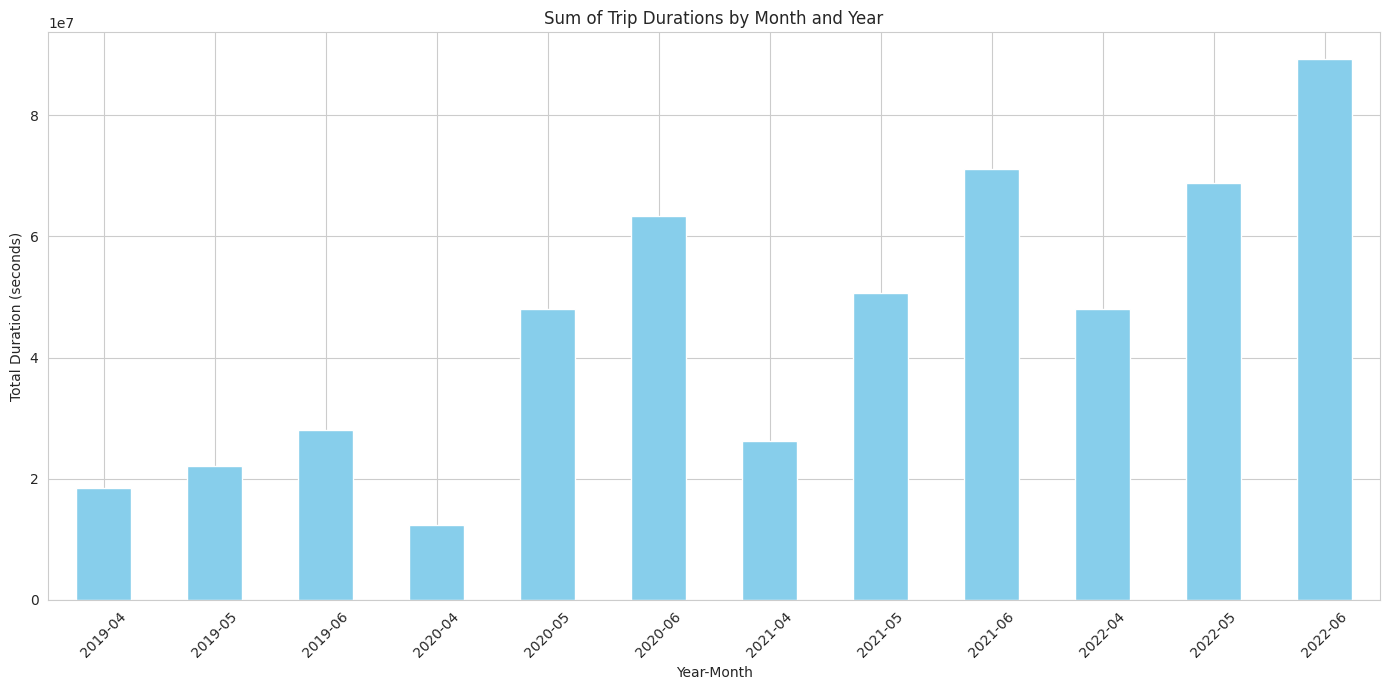

In [32]:
# Ensure the 'started_at' column is in datetime format
combined_df['started_at'] = pd.to_datetime(combined_df['started_at'])

# Extract the year and month from the 'started_at' column
combined_df['year'] = combined_df['started_at'].dt.year
combined_df['month'] = combined_df['started_at'].dt.month

# Group by the extracted year and month and sum the durations
monthly_duration_sum = combined_df.groupby(['year', 'month'])['duration'].sum()

# Convert the index to a more readable format (e.g., '2021-01', '2021-02', ...)
monthly_duration_sum.index = monthly_duration_sum.index.map(lambda x: f"{x[0]}-{x[1]:02d}")

# Plotting the results
plt.figure(figsize=(14, 7))
monthly_duration_sum.plot(kind='bar', color='skyblue')
plt.title('Sum of Trip Durations by Month and Year')
plt.xlabel('Year-Month')
plt.ylabel('Total Duration (seconds)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()


In [ ]:
# Create the histogram
sns.histplot(combined_df['TMAX'], bins=24, kde=True)  # 'kde' adds a Kernel Density Estimate line
plt.title('start_hour Distribution')
plt.xlabel('start_hour')
plt.ylabel('Frequency')
plt.show()

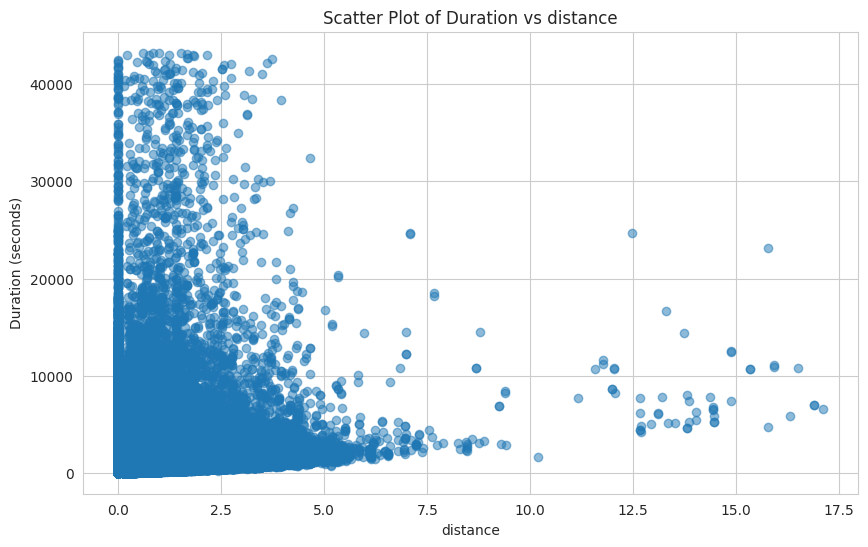

In [155]:
# Create the scatter plot
plt.figure(figsize=(10, 6))  # Set the size of the figure
plt.scatter(combined_df['distance'], combined_df['duration'], alpha=0.5)  # alpha sets the transparency
plt.title('Scatter Plot of Duration vs distance')  # Add a title
plt.xlabel('distance')  # Label the x-axis
plt.ylabel('Duration (seconds)')  # Label the y-axis
plt.show()

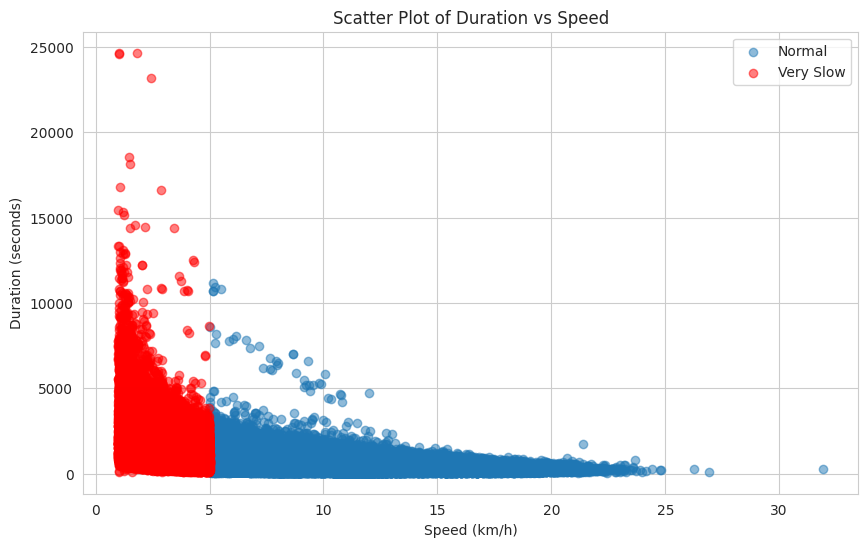

In [26]:
plot_df = combined_df.copy()

plt.figure(figsize=(10, 6))
plt.scatter(plot_df[plot_df['very_slow'] == False]['speed_kmh'],
            plot_df[plot_df['very_slow'] == False]['duration'],
            alpha=0.5, label='Normal')
plt.scatter(plot_df[plot_df['very_slow'] == True]['speed_kmh'],
            plot_df[plot_df['very_slow'] == True]['duration'],
            alpha=0.5, color='red', label='Very Slow')
plt.title('Scatter Plot of Duration vs Speed')
plt.xlabel('Speed (km/h)')
plt.ylabel('Duration (seconds)')
plt.legend()
plt.show()


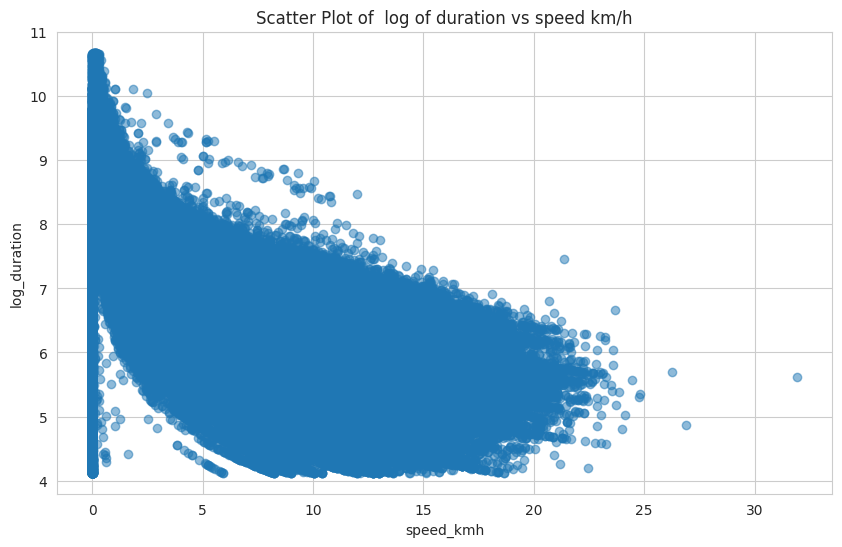

In [34]:
# Create the scatter plot
plt.figure(figsize=(10, 6))  # Set the size of the figure
plt.scatter(combined_df['speed_kmh'], combined_df['log_duration'], alpha=0.5)  # alpha sets the transparency
plt.title('Scatter Plot of  log of duration vs speed km/h')  # Add a title
plt.xlabel('speed_kmh')  # Label the x-axis
plt.ylabel('log_duration')  # Label the y-axis
plt.show()

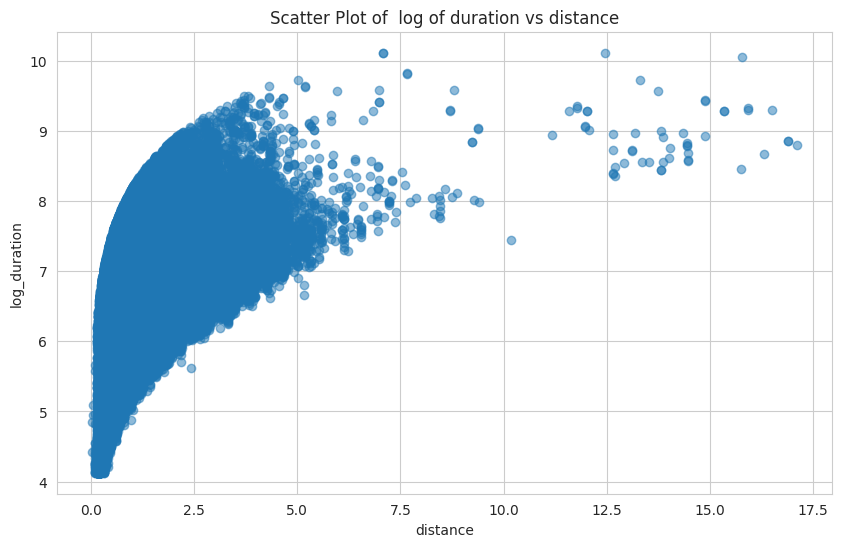

In [70]:
# Create the scatter plot
plt.figure(figsize=(10, 6))  # Set the size of the figure
plt.scatter(combined_df['distance'], combined_df['log_duration'], alpha=0.5)  # alpha sets the transparency
plt.title('Scatter Plot of  log of duration vs distance')  # Add a title
plt.xlabel('distance')  # Label the x-axis
plt.ylabel('log_duration')  # Label the y-axis
plt.show()

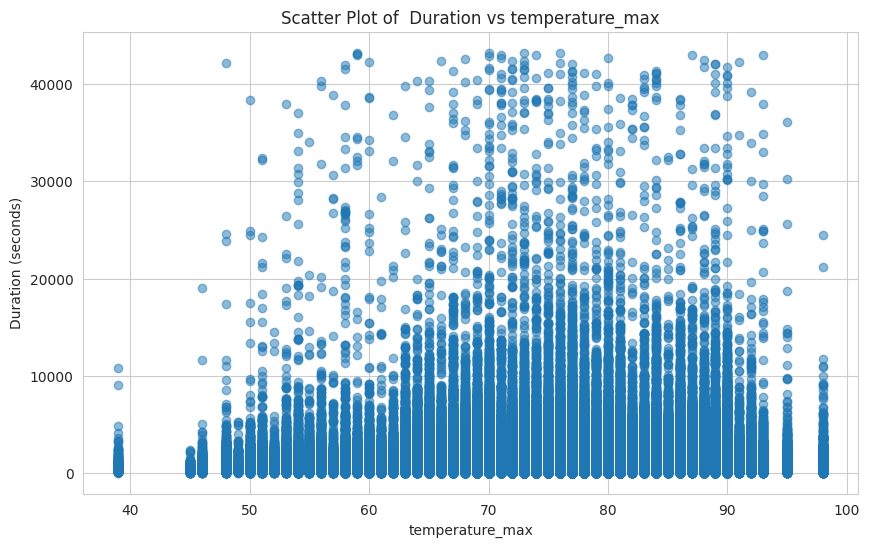

In [157]:
# Create the scatter plot
plt.figure(figsize=(10, 6))  # Set the size of the figure
plt.scatter(combined_df['TMAX'], combined_df['duration'], alpha=0.5)  # alpha sets the transparency
plt.title('Scatter Plot of  Duration vs temperature_max')  # Add a title
plt.xlabel('temperature_max')  # Label the x-axis
plt.ylabel('Duration (seconds)')  # Label the y-axis
plt.show()

# Data Splitting

In [36]:
#Importing RFE and Linear Regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA

In [37]:
independent_variables=['start_hour',
                       'member_casual', 'log_speed', 'distance',
                       'PRCP', 'TMIN', 'TMAX', 'start_weekday', 'end_weekday', 'very_slow']

dependent_variables = 'log_duration'

# Create the data of independent variables
X = combined_df[independent_variables]
# Create the dependent variable data
y = combined_df[dependent_variables]

# Splitting the dataset into the Training, Validation and Testing set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Linear Regression

In [38]:
# Fitting Multiple Linear Regression to the Training set
from sklearn.linear_model import LinearRegression
linear_reg =  LinearRegression()

#Aplly model on train dataset
linear_reg.fit(X_train, y_train)
#model score on train dataset
linear_reg.score(X_train, y_train)

0.7803911107319749

In [41]:
# Training the model
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Evaluating the model on the training data
train_pred = linear_reg.predict(X_train)
train_mse = mean_squared_error(y_train, train_pred)
train_r2 = r2_score(y_train, train_pred)
print(f"Training MSE: {train_mse:.5f}, R^2: {train_r2:.5f}")

# Fine-tuning and validating the model on the validation set
val_pred = linear_reg.predict(X_val)
val_mse = mean_squared_error(y_val, val_pred)
val_r2 = r2_score(y_val, val_pred)
print(f"Validation MSE: {val_mse:.5f}, R^2: {val_r2:.5f}")

Training MSE: 0.19165, R^2: 0.78039
Validation MSE: 0.18720, R^2: 0.78471


In [42]:
# Evaluating the model on the test set (unseen data)
test_pred = linear_reg.predict(X_test)
test_mse = mean_squared_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)
print(f"Test MSE: {test_mse:.5f}, R^2: {test_r2:.5f}")

Test MSE: 0.19093, R^2: 0.78089


# XGBOOST

In [43]:
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold

In [45]:
# Create the XGBoost regression model
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    gamma=0.1,
    reg_lambda=1.0,
    reg_alpha=0.1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [81]:
# Configure the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)

# Evaluate model using each iteration of the cross-validation
scores_mse = cross_val_score(xgb_model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
scores_r2 = cross_val_score(xgb_model, X_train, y_train, scoring='r2', cv=cv, n_jobs=-1)
# Convert scores to positive values
mse_scores = -scores_mse
r2_scores = scores_r2

# Report performance
print('MSE: %.3f (%.3f)' % (np.mean(mse_scores), np.std(mse_scores)))
print('R^2: %.3f (%.3f)' % (np.mean(r2_scores), np.std(r2_scores)))

MSE: 5006.623 (2861.988)
R^2: 0.988 (0.007)


In [46]:
# Evaluating the model on the training data
train_pred = xgb_model.predict(X_train)
train_mse = mean_squared_error(y_train, train_pred)
train_r2 = r2_score(y_train, train_pred)
print(f"Training MSE: {train_mse}, R^2: {train_r2}")

# Fine-tuning and validating the model on the validation set
val_pred = xgb_model.predict(X_val)
val_mse = mean_squared_error(y_val, val_pred)
val_r2 = r2_score(y_val, val_pred)
print(f"Validation MSE: {val_mse}, R^2: {val_r2}")

Training MSE: 0.08979147799217228, R^2: 0.8971117891526498
Validation MSE: 0.09291958861094257, R^2: 0.8931349133642825


In [47]:
# Evaluating the model on the test set (unseen data)
test_pred = xgb_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)
print(f"Test MSE: {test_mse}, R^2: {test_r2}")

Test MSE: 0.0929692202385635, R^2: 0.8933083712771357


# Random Forest

In [48]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [49]:
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

random_forest_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [50]:
# Evaluating the model on the training data
train_pred = random_forest_model.predict(X_train)
train_mse = mean_squared_error(y_train, train_pred)
train_r2 = r2_score(y_train, train_pred)
print(f"Training MSE: {train_mse}, R^2: {train_r2}")

# Fine-tuning and validating the model on the validation set
val_pred = random_forest_model.predict(X_val)
val_mse = mean_squared_error(y_val, val_pred)
val_r2 = r2_score(y_val, val_pred)
print(f"Validation MSE: {val_mse}, R^2: {val_r2}")

Training MSE: 0.0632983889374158, R^2: 0.9274690857872039
Validation MSE: 0.10235634454468133, R^2: 0.8822818762867985


In [51]:
# Evaluating the model on the test set (unseen data)
test_pred = random_forest_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)
print(f"Test MSE: {test_mse}, R^2: {test_r2}")

Test MSE: 0.10099382854537968, R^2: 0.8840993177009058
